In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary
from torch.autograd import Variable

# https://disassemble-channel.com/lstm-multivariate-time-series/
を参考にやっていくやつ

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/aweglteo/tokyo_weather_data/main/data.csv", parse_dates=True, index_col=0)
df

,cloud,wind,ave_tmp,max_tmp,min_tmp,rain
2018-05-17,9.0,3.7,24.0,28.4,21.4,0.0
2018-05-18,7.8,3.0,23.4,27.1,20.0,0.0
2018-05-19,7.5,3.9,21.5,26.3,15.3,0.0
2018-05-20,4.3,3.5,16.8,22.1,13.1,0.0
2018-05-21,10.0,2.4,20.3,27.2,13.7,0.0
...,...,...,...,...,...,...
2023-05-13,10.0,3.0,16.7,18.1,15.4,5.0
2023-05-14,10.0,3.6,16.9,21.2,14.3,3.0
2023-05-15,9.8,2.0,16.1,18.1,14.6,15.5
2023-05-16,2.8,2.6,19.9,27.5,13.1,0.0


In [3]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['cloud', 'wind', 'ave_tmp', 'max_tmp', 'min_tmp', 'rain']])
df_scaled

array([[0.9       , 0.40322581, 0.74769231, 0.70879121, 0.778125  ,
        0.        ],
       [0.78      , 0.29032258, 0.72923077, 0.67307692, 0.734375  ,
        0.        ],
       [0.75      , 0.43548387, 0.67076923, 0.6510989 , 0.5875    ,
        0.        ],
       ...,
       [0.98      , 0.12903226, 0.50461538, 0.42582418, 0.565625  ,
        0.07398568],
       [0.28      , 0.22580645, 0.62153846, 0.68406593, 0.51875   ,
        0.        ],
       [0.        , 0.17741935, 0.71076923, 0.7967033 , 0.58125   ,
        0.        ]])

In [4]:
# テスト用と訓練用で分割
df_train, df_test = train_test_split(df_scaled, test_size=0.3, shuffle=False)

window_size = 20
n_data = len(df) - window_size + 1 -1

n_dim = df_train.shape[1]
n_train = len(df_train) - window_size + 1 - 1
n_test = len(df_test) - window_size + 1 - 1

# 正解データを準備
train = np.zeros((n_train, window_size, n_dim))
train_labels = np.zeros((n_train, n_dim))
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    train_labels[i] = df_train[i+window_size]

# テストデータを準備
test = np.zeros((n_test, window_size, n_dim))
test_labels = np.zeros((n_test, n_dim))
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    test_labels[i] = df_test[i+window_size]

# 訓練ラベルの用意。今回は平均気温を予測する
train_labels =train_labels[:, 2]

In [5]:
train = torch.tensor(train, dtype=torch.float)
labels = torch.tensor(train_labels, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(train, labels)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [10]:
# 多変量を入力して、１変数の予測結果を返すLSTNモデル.
class MyLSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_output = 1

        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.n_output)

    def forward(self, x):
        h_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        c_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_dim) 
        y = self.fc(hn)
        y = y.reshape(self.n_output, -1)

        return y


feature_size  = 6
n_hidden  = 64
n_layers  = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = MyLSTM(feature_size, n_hidden, n_layers).to(device)

In [11]:
summary(net)

Layer (type:depth-idx)                   Param #
MyLSTM                                   --
├─LSTM: 1-1                              18,432
├─Linear: 1-2                            65
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0

In [12]:
func_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_history = []

print(f"run with {device}")
epochs = 200

net.to(device)

run with cuda


MyLSTM(
  (lstm): LSTM(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
for i in range(epochs+1):
    net.train()
    tmp_loss = 0.0
    for j, (x, t) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        y = net(x) 
        loss = func_loss(y, t)
        loss.backward()
        optimizer.step() 
        tmp_loss += loss.item()
    tmp_loss /= j+1
    loss_history.append(tmp_loss)
    print('Epoch:', i, 'Loss_Train:', tmp_loss)

C:\Users\drryu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\drryu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss_Train: 0.025464073266272272
Epoch: 1 Loss_Train: 0.005945993493503285
Epoch: 2 Loss_Train: 0.005523430860332502
Epoch: 3 Loss_Train: 0.00491882666401724
Epoch: 4 Loss_Train: 0.0046603025212543945
Epoch: 5 Loss_Train: 0.004488793900698453
Epoch: 6 Loss_Train: 0.004333870101878087
Epoch: 7 Loss_Train: 0.004185104495217462
Epoch: 8 Loss_Train: 0.00403946091669024
Epoch: 9 Loss_Train: 0.004088354502556964
Epoch: 10 Loss_Train: 0.004195399012690085
Epoch: 11 Loss_Train: 0.003881661823764998
Epoch: 12 Loss_Train: 0.0038284551938265812
Epoch: 13 Loss_Train: 0.0038754336650729075
Epoch: 14 Loss_Train: 0.003957668563678107
Epoch: 15 Loss_Train: 0.003789008840584078
Epoch: 16 Loss_Train: 0.0038060608071862675
Epoch: 17 Loss_Train: 0.0038766175042606876
Epoch: 18 Loss_Train: 0.0038241104561916833
Epoch: 19 Loss_Train: 0.003697933172825576
Epoch: 20 Loss_Train: 0.0037987022762074104
Epoch: 21 Loss_Train: 0.0038305248446126898
Epoch: 22 Loss_Train: 0.003651777453584752
Epoch: 23 Loss_

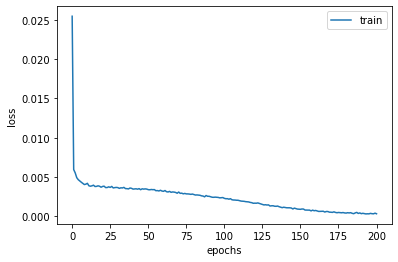

In [14]:
plt.plot(range(len(loss_history)), loss_history, label='train')
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [18]:
predicted_train_plot = []
net.eval()

for k in range(n_train):
    x = torch.tensor(train[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_train_plot.append(y[0].item())
    

C:\Users\drryu\AppData\Local\Temp\ipykernel_7944\1814804422.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train[k])


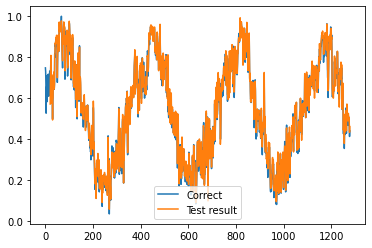

In [21]:

plt.plot(range(len(df_train)), df_train[:, 2], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_train_plot)), predicted_train_plot, label='Test result')
plt.legend()
plt.show()

In [25]:
predicted_test_plot = []
net.eval()

for k in range(n_test):
    x = torch.tensor(test[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    predicted_test_plot.append(y[0].item())

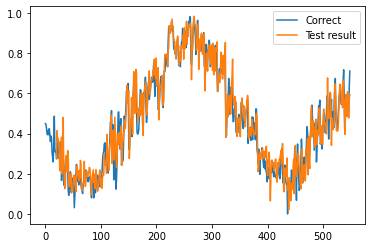

In [26]:
plt.plot(range(len(df_test)), df_test[:, 2], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Test result')
plt.legend()
plt.show()